In [ ]:
import sys
import shutil
import time
import resource
import json
from pathlib import Path

from scipy.stats import multivariate_normal, norm

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, Callback
#from keras.metrics import AUC, RootMeanSquaredError
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import r2_score, auc, roc_curve, roc_auc_score, log_loss, fbeta_score,precision_recall_curve, mean_squared_error, mean_absolute_error

import nn_models as nnm
import dataprocessing as dp
import visualization as viz

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class HyperANNAutoencoder(kt.HyperModel):
    def __init__(self, num_input_features):
        super(HyperANNAutoencoder, self).__init__()
        self.num_input = num_input_features

        hp_units_1 = hp.Int('outer-layer', min_value=32, max_value=64, step=4)
        hp_units_2 = hp.Int('middle-layer', min_value=12, max_value=28, step=4)
        hp_units_3 = hp.Int('inner-layer', min_value=4, max_value=8, step=2)
        
        self.encoder = tf.keras.Sequential([
          tf.keras.layers.Dense(hp_units_1, activation="relu"),
          tf.keras.layers.Dense(hp_units_2, activation="relu"),
          tf.keras.layers.Dense(hp_units_3, activation="relu")])

        self.decoder = tf.keras.Sequential([
          tf.keras.layers.Dense(hp_units_2, activation="relu"),
          tf.keras.layers.Dense(hp_units_1, activation="relu"),
          tf.keras.layers.Dense(self.num_input, activation="linear")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        # Tune the learning rate
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-3])

        decoded.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                            loss='mean_squared_error')
        return decoded

In [2]:
class AnomalyDetector(Model):
    def __init__(self, num_input_features):
        super(AnomalyDetector, self).__init__()
        self.num_input = num_input_features

        self.encoder = tf.keras.Sequential([
          tf.keras.layers.Dense(32, activation="relu"),
          tf.keras.layers.Dense(16, activation="relu"),
          tf.keras.layers.Dense(8, activation="relu")])

        self.decoder = tf.keras.Sequential([
          tf.keras.layers.Dense(16, activation="relu"),
          tf.keras.layers.Dense(32, activation="relu"),
          tf.keras.layers.Dense(self.num_input, activation="linear")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
### Test running the model
loss = 'mean_squared_error'
TIME_STEPS = 24
BATCH_SIZE = 128
num_features = 2

### Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')


In [4]:
### Load the data ###
data, varnames, target = dp.load_data_nn('3-jk', sensor='both', dlh=0, 
                                         keep_SH=False, return_target=True, smote=None)

The beginning shape is:  (10221, 99)
After dropping rows with NaN in the SH_Event columns, the shape is:  (10011, 99)
NaN values in this dataset:  False
The left data frame set shape is:  (10011, 48)
The right data frame set shape is:  (10011, 48)
The keep left data frame set shape is:  (10011, 24)
The keep right data frame set shape is:  (10011, 24)
Not adding fake positive data samples.


In [5]:
### Split the data into train, val, and testing
target = np.where(target == 1, 1, 0)

train_idx, val_idx, test_idx = dp.split_data_cv_indx(data,target)

# Prepare data for the autoencoder model
normal, anomalous = dp.process_autoencoder(data[train_idx], data[test_idx], data[val_idx],
                                           target[train_idx], target[test_idx], target[val_idx])

normal_train, normal_val, normal_train_target, normal_val_target             = normal
anomalous_train, anomalous_val, anomalous_train_target, anomalous_val_target = anomalous

# Try Normalizing the data
#scaled_normal_train, scaled_test, scaled_normal_val = dp.normalize_data(normal_train, data[test_idx], normal_val)

train_data = normal_train # scaled_normal_train #
y_train    = normal_train_target

test_data  = data[test_idx] #scaled_test #
y_test     = target[test_idx]

val_data   = normal_val #scaled_normal_val #
y_val      = normal_val_target

print("Anomalous train data shape is: ", anomalous_train.shape)
print("Anomalous val data shape is: ", anomalous_val.shape)

Train labels shape:  (2380,)
Test labels shape:  (5836,)
Val labels shape:  (1795,)
Normal train data shape is:  (2345, 48)
Normal test data shape is:  (5824, 48)
Normal val data shape is:  (1783, 48)
Anomalous train data shape is:  (35, 48)
Anomalous test data shape is:  (12, 48)
Anomalous val data shape is:  (12, 48)
Anomalous train data shape is:  (35, 48)
Anomalous val data shape is:  (12, 48)


In [52]:
# Test single model
autoencoder = AnomalyDetector(48) #, timesteps) #nnm.AnomalyDetector(data.shape[1])

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                    loss='mean_squared_error')
                    #metrics=[tf.keras.metrics.Precision(name='precision'),
                    #                tf.keras.metrics.Recall(name='recall'),
                    #                tf.keras.metrics.AUC(name='auc'),
                    #                tf.keras.metrics.AUC(name='prc', curve='PR')])

history = autoencoder.fit(train_data, train_data,
          epochs=15000, callbacks = [early_stopping],
          validation_split=0.2, batch_size=BATCH_SIZE)
          #validation_data=(val_data, val_data))

Epoch 1/15000
15/15 [==============================] - 1s 22ms/step - loss: 15047.0479 - val_loss: 14551.6055
Epoch 2/15000
15/15 [==============================] - 0s 6ms/step - loss: 15023.9336 - val_loss: 14530.9102
Epoch 3/15000
15/15 [==============================] - 0s 6ms/step - loss: 15003.0039 - val_loss: 14512.0918
Epoch 4/15000
15/15 [==============================] - 0s 6ms/step - loss: 14984.2422 - val_loss: 14494.5264
Epoch 5/15000
15/15 [==============================] - 0s 5ms/step - loss: 14966.5820 - val_loss: 14478.5117
Epoch 6/15000
15/15 [==============================] - 0s 5ms/step - loss: 14950.3232 - val_loss: 14463.2900
Epoch 7/15000
15/15 [==============================] - 0s 5ms/step - loss: 14934.5205 - val_loss: 14449.1475
Epoch 8/15000
15/15 [==============================] - 0s 5ms/step - loss: 14919.7363 - val_loss: 14435.5498
Epoch 9/15000
15/15 [==============================] - 0s 5ms/step - loss: 14905.4111 - val_loss: 14422.6523
Epoch 10/15000
15/

Epoch 150/15000
15/15 [==============================] - 0s 4ms/step - loss: 8089.7925 - val_loss: 7751.9648
Epoch 151/15000
15/15 [==============================] - 0s 4ms/step - loss: 8039.8818 - val_loss: 7703.8677
Epoch 152/15000
15/15 [==============================] - 0s 4ms/step - loss: 7990.2822 - val_loss: 7655.4321
Epoch 153/15000
15/15 [==============================] - 0s 4ms/step - loss: 7940.8027 - val_loss: 7605.8379
Epoch 154/15000
15/15 [==============================] - 0s 8ms/step - loss: 7889.0244 - val_loss: 7556.1982
Epoch 155/15000
15/15 [==============================] - 0s 4ms/step - loss: 7837.4487 - val_loss: 7502.9253
Epoch 156/15000
15/15 [==============================] - 0s 4ms/step - loss: 7781.2476 - val_loss: 7447.2900
Epoch 157/15000
15/15 [==============================] - 0s 4ms/step - loss: 7721.9902 - val_loss: 7386.1582
Epoch 158/15000
15/15 [==============================] - 0s 6ms/step - loss: 7657.7363 - val_loss: 7320.9521
Epoch 159/15000
15/

15/15 [==============================] - 0s 6ms/step - loss: 1909.6553 - val_loss: 1753.7993
Epoch 301/15000
15/15 [==============================] - 0s 5ms/step - loss: 1893.6426 - val_loss: 1738.4364
Epoch 302/15000
15/15 [==============================] - 0s 6ms/step - loss: 1877.8706 - val_loss: 1723.1608
Epoch 303/15000
15/15 [==============================] - 0s 7ms/step - loss: 1862.2738 - val_loss: 1708.0219
Epoch 304/15000
15/15 [==============================] - 0s 6ms/step - loss: 1847.0128 - val_loss: 1692.9453
Epoch 305/15000
15/15 [==============================] - 0s 5ms/step - loss: 1831.7808 - val_loss: 1678.1920
Epoch 306/15000
15/15 [==============================] - 0s 5ms/step - loss: 1816.8513 - val_loss: 1663.6096
Epoch 307/15000
15/15 [==============================] - 0s 5ms/step - loss: 1802.0115 - val_loss: 1649.3712
Epoch 308/15000
15/15 [==============================] - 0s 4ms/step - loss: 1787.4437 - val_loss: 1635.2126
Epoch 309/15000
15/15 [============

15/15 [==============================] - 0s 8ms/step - loss: 945.3391 - val_loss: 828.6941
Epoch 452/15000
15/15 [==============================] - 0s 14ms/step - loss: 943.9305 - val_loss: 827.4645
Epoch 453/15000
15/15 [==============================] - 0s 9ms/step - loss: 942.5704 - val_loss: 826.1875
Epoch 454/15000
15/15 [==============================] - 0s 10ms/step - loss: 941.2247 - val_loss: 824.9251
Epoch 455/15000
15/15 [==============================] - 0s 7ms/step - loss: 939.8537 - val_loss: 823.7209
Epoch 456/15000
15/15 [==============================] - 0s 8ms/step - loss: 938.5513 - val_loss: 822.5064
Epoch 457/15000
15/15 [==============================] - 0s 6ms/step - loss: 937.2032 - val_loss: 821.3152
Epoch 458/15000
15/15 [==============================] - 0s 6ms/step - loss: 935.9069 - val_loss: 820.1655
Epoch 459/15000
15/15 [==============================] - 0s 8ms/step - loss: 934.6115 - val_loss: 818.9406
Epoch 460/15000
15/15 [============================

15/15 [==============================] - 0s 4ms/step - loss: 760.0305 - val_loss: 671.2557
Epoch 604/15000
15/15 [==============================] - 0s 5ms/step - loss: 758.7402 - val_loss: 670.2247
Epoch 605/15000
15/15 [==============================] - 0s 5ms/step - loss: 757.4666 - val_loss: 669.0957
Epoch 606/15000
15/15 [==============================] - 0s 5ms/step - loss: 756.1812 - val_loss: 668.0261
Epoch 607/15000
15/15 [==============================] - 0s 5ms/step - loss: 754.9216 - val_loss: 667.0203
Epoch 608/15000
15/15 [==============================] - 0s 4ms/step - loss: 753.6060 - val_loss: 665.9294
Epoch 609/15000
15/15 [==============================] - 0s 4ms/step - loss: 752.3291 - val_loss: 664.8573
Epoch 610/15000
15/15 [==============================] - 0s 4ms/step - loss: 751.0349 - val_loss: 663.7785
Epoch 611/15000
15/15 [==============================] - 0s 4ms/step - loss: 749.7433 - val_loss: 662.6882
Epoch 612/15000
15/15 [==============================

15/15 [==============================] - 0s 7ms/step - loss: 572.6265 - val_loss: 513.7258
Epoch 756/15000
15/15 [==============================] - 0s 8ms/step - loss: 571.4531 - val_loss: 512.8017
Epoch 757/15000
15/15 [==============================] - 0s 8ms/step - loss: 570.3449 - val_loss: 511.8211
Epoch 758/15000
15/15 [==============================] - 0s 8ms/step - loss: 569.2936 - val_loss: 510.8676
Epoch 759/15000
15/15 [==============================] - 0s 12ms/step - loss: 568.0877 - val_loss: 509.9244
Epoch 760/15000
15/15 [==============================] - 0s 7ms/step - loss: 567.0103 - val_loss: 509.0115
Epoch 761/15000
15/15 [==============================] - 0s 9ms/step - loss: 565.8735 - val_loss: 508.0662
Epoch 762/15000
15/15 [==============================] - 0s 13ms/step - loss: 564.7536 - val_loss: 507.1331
Epoch 763/15000
15/15 [==============================] - 0s 13ms/step - loss: 563.6491 - val_loss: 506.1988
Epoch 764/15000
15/15 [===========================

15/15 [==============================] - 0s 6ms/step - loss: 434.4059 - val_loss: 397.4056
Epoch 908/15000
15/15 [==============================] - 0s 5ms/step - loss: 433.7489 - val_loss: 396.9081
Epoch 909/15000
15/15 [==============================] - 0s 4ms/step - loss: 433.0967 - val_loss: 396.3411
Epoch 910/15000
15/15 [==============================] - 0s 5ms/step - loss: 432.4596 - val_loss: 395.8486
Epoch 911/15000
15/15 [==============================] - 0s 5ms/step - loss: 431.8267 - val_loss: 395.2521
Epoch 912/15000
15/15 [==============================] - 0s 6ms/step - loss: 431.1590 - val_loss: 394.7357
Epoch 913/15000
15/15 [==============================] - 0s 7ms/step - loss: 430.5381 - val_loss: 394.2506
Epoch 914/15000
15/15 [==============================] - 0s 5ms/step - loss: 429.8871 - val_loss: 393.6628
Epoch 915/15000
15/15 [==============================] - 0s 5ms/step - loss: 429.2532 - val_loss: 393.1621
Epoch 916/15000
15/15 [==============================

15/15 [==============================] - 0s 4ms/step - loss: 368.0916 - val_loss: 343.4077
Epoch 1060/15000
15/15 [==============================] - 0s 4ms/step - loss: 367.8431 - val_loss: 343.1528
Epoch 1061/15000
15/15 [==============================] - 0s 4ms/step - loss: 367.6291 - val_loss: 342.9343
Epoch 1062/15000
15/15 [==============================] - 0s 7ms/step - loss: 367.4016 - val_loss: 342.8100
Epoch 1063/15000
15/15 [==============================] - 0s 5ms/step - loss: 367.1421 - val_loss: 342.6916
Epoch 1064/15000
15/15 [==============================] - 0s 5ms/step - loss: 366.9268 - val_loss: 342.4805
Epoch 1065/15000
15/15 [==============================] - 0s 5ms/step - loss: 366.6897 - val_loss: 342.2972
Epoch 1066/15000
15/15 [==============================] - 0s 5ms/step - loss: 366.4583 - val_loss: 342.1515
Epoch 1067/15000
15/15 [==============================] - 0s 5ms/step - loss: 366.2374 - val_loss: 341.9124
Epoch 1068/15000
15/15 [=====================

15/15 [==============================] - 0s 6ms/step - loss: 354.0039 - val_loss: 332.0810
Epoch 1136/15000
15/15 [==============================] - 0s 11ms/step - loss: 353.8760 - val_loss: 331.9903
Epoch 1137/15000
15/15 [==============================] - 0s 7ms/step - loss: 353.7126 - val_loss: 331.8652
Epoch 1138/15000
15/15 [==============================] - 0s 5ms/step - loss: 353.5693 - val_loss: 331.7426
Epoch 1139/15000
15/15 [==============================] - 0s 4ms/step - loss: 353.4431 - val_loss: 331.5914
Epoch 1140/15000
15/15 [==============================] - 0s 4ms/step - loss: 353.2885 - val_loss: 331.4591
Epoch 1141/15000
15/15 [==============================] - 0s 4ms/step - loss: 353.1409 - val_loss: 331.3912
Epoch 1142/15000
15/15 [==============================] - 0s 6ms/step - loss: 353.0031 - val_loss: 331.2354
Epoch 1143/15000
15/15 [==============================] - 0s 4ms/step - loss: 352.9019 - val_loss: 331.2306
Epoch 1144/15000
15/15 [====================

Epoch 1211/15000
15/15 [==============================] - 0s 5ms/step - loss: 344.0955 - val_loss: 323.8905
Epoch 1212/15000
15/15 [==============================] - 0s 5ms/step - loss: 343.9659 - val_loss: 323.8796
Epoch 1213/15000
15/15 [==============================] - 0s 10ms/step - loss: 343.8492 - val_loss: 323.7602
Epoch 1214/15000
15/15 [==============================] - 0s 9ms/step - loss: 343.7244 - val_loss: 323.6128
Epoch 1215/15000
15/15 [==============================] - 0s 8ms/step - loss: 343.5937 - val_loss: 323.5789
Epoch 1216/15000
15/15 [==============================] - 0s 5ms/step - loss: 343.4492 - val_loss: 323.4182
Epoch 1217/15000
15/15 [==============================] - 0s 5ms/step - loss: 343.3398 - val_loss: 323.2179
Epoch 1218/15000
15/15 [==============================] - 0s 7ms/step - loss: 343.2201 - val_loss: 323.2091
Epoch 1219/15000
15/15 [==============================] - 0s 5ms/step - loss: 343.0828 - val_loss: 323.1357
Epoch 1220/15000
15/15 [===

Epoch 1287/15000
15/15 [==============================] - 0s 5ms/step - loss: 334.2346 - val_loss: 315.6017
Epoch 1288/15000
15/15 [==============================] - 0s 6ms/step - loss: 334.1302 - val_loss: 315.6058
Epoch 1289/15000
15/15 [==============================] - 0s 5ms/step - loss: 333.9525 - val_loss: 315.4490
Epoch 1290/15000
15/15 [==============================] - 0s 4ms/step - loss: 333.8157 - val_loss: 315.2638
Epoch 1291/15000
15/15 [==============================] - 0s 6ms/step - loss: 333.6737 - val_loss: 315.1896
Epoch 1292/15000
15/15 [==============================] - 0s 5ms/step - loss: 333.5640 - val_loss: 315.0717
Epoch 1293/15000
15/15 [==============================] - 0s 6ms/step - loss: 333.4426 - val_loss: 314.9638
Epoch 1294/15000
15/15 [==============================] - 0s 5ms/step - loss: 333.2548 - val_loss: 314.8261
Epoch 1295/15000
15/15 [==============================] - 0s 5ms/step - loss: 333.1133 - val_loss: 314.7900
Epoch 1296/15000
15/15 [====

Epoch 1363/15000
15/15 [==============================] - 0s 6ms/step - loss: 322.8062 - val_loss: 305.9365
Epoch 1364/15000
15/15 [==============================] - 0s 8ms/step - loss: 322.6690 - val_loss: 305.7585
Epoch 1365/15000
15/15 [==============================] - 0s 5ms/step - loss: 322.4759 - val_loss: 305.5955
Epoch 1366/15000
15/15 [==============================] - 0s 5ms/step - loss: 322.3281 - val_loss: 305.5891
Epoch 1367/15000
15/15 [==============================] - 0s 5ms/step - loss: 322.1697 - val_loss: 305.3516
Epoch 1368/15000
15/15 [==============================] - 0s 6ms/step - loss: 321.9980 - val_loss: 305.2387
Epoch 1369/15000
15/15 [==============================] - 0s 6ms/step - loss: 321.8353 - val_loss: 305.0531
Epoch 1370/15000
15/15 [==============================] - 0s 5ms/step - loss: 321.6669 - val_loss: 305.0317
Epoch 1371/15000
15/15 [==============================] - 0s 5ms/step - loss: 321.5197 - val_loss: 304.8965
Epoch 1372/15000
15/15 [====

Epoch 1439/15000
15/15 [==============================] - 0s 4ms/step - loss: 309.3854 - val_loss: 294.4070
Epoch 1440/15000
15/15 [==============================] - 0s 4ms/step - loss: 309.2101 - val_loss: 294.2612
Epoch 1441/15000
15/15 [==============================] - 0s 4ms/step - loss: 309.0112 - val_loss: 294.1771
Epoch 1442/15000
15/15 [==============================] - 0s 5ms/step - loss: 308.8386 - val_loss: 293.9216
Epoch 1443/15000
15/15 [==============================] - 0s 4ms/step - loss: 308.6242 - val_loss: 293.8651
Epoch 1444/15000
15/15 [==============================] - 0s 4ms/step - loss: 308.4375 - val_loss: 293.6416
Epoch 1445/15000
15/15 [==============================] - 0s 4ms/step - loss: 308.2525 - val_loss: 293.4373
Epoch 1446/15000
15/15 [==============================] - 0s 5ms/step - loss: 308.0563 - val_loss: 293.2684
Epoch 1447/15000
15/15 [==============================] - 0s 6ms/step - loss: 307.8720 - val_loss: 293.1571
Epoch 1448/15000
15/15 [====

Epoch 1515/15000
15/15 [==============================] - 0s 4ms/step - loss: 294.1821 - val_loss: 281.4672
Epoch 1516/15000
15/15 [==============================] - 0s 4ms/step - loss: 293.9880 - val_loss: 281.3126
Epoch 1517/15000
15/15 [==============================] - 0s 4ms/step - loss: 293.7615 - val_loss: 281.0947
Epoch 1518/15000
15/15 [==============================] - 0s 5ms/step - loss: 293.5544 - val_loss: 280.8962
Epoch 1519/15000
15/15 [==============================] - 0s 6ms/step - loss: 293.3591 - val_loss: 280.7127
Epoch 1520/15000
15/15 [==============================] - 0s 5ms/step - loss: 293.1413 - val_loss: 280.4798
Epoch 1521/15000
15/15 [==============================] - 0s 4ms/step - loss: 292.9276 - val_loss: 280.3310
Epoch 1522/15000
15/15 [==============================] - 0s 4ms/step - loss: 292.7147 - val_loss: 280.1506
Epoch 1523/15000
15/15 [==============================] - 0s 4ms/step - loss: 292.5021 - val_loss: 279.9619
Epoch 1524/15000
15/15 [====

Epoch 1591/15000
15/15 [==============================] - 0s 4ms/step - loss: 277.8606 - val_loss: 267.2769
Epoch 1592/15000
15/15 [==============================] - 0s 5ms/step - loss: 277.6299 - val_loss: 267.1538
Epoch 1593/15000
15/15 [==============================] - 0s 5ms/step - loss: 277.4234 - val_loss: 266.9522
Epoch 1594/15000
15/15 [==============================] - 0s 4ms/step - loss: 277.1972 - val_loss: 266.7409
Epoch 1595/15000
15/15 [==============================] - 0s 5ms/step - loss: 276.9709 - val_loss: 266.5628
Epoch 1596/15000
15/15 [==============================] - 0s 4ms/step - loss: 276.7630 - val_loss: 266.3891
Epoch 1597/15000
15/15 [==============================] - 0s 4ms/step - loss: 276.5370 - val_loss: 266.2321
Epoch 1598/15000
15/15 [==============================] - 0s 4ms/step - loss: 276.3255 - val_loss: 265.9875
Epoch 1599/15000
15/15 [==============================] - 0s 4ms/step - loss: 276.0854 - val_loss: 265.7571
Epoch 1600/15000
15/15 [====

Epoch 1667/15000
15/15 [==============================] - 0s 5ms/step - loss: 261.1228 - val_loss: 252.9400
Epoch 1668/15000
15/15 [==============================] - 0s 5ms/step - loss: 260.8960 - val_loss: 252.7229
Epoch 1669/15000
15/15 [==============================] - 0s 6ms/step - loss: 260.6721 - val_loss: 252.5709
Epoch 1670/15000
15/15 [==============================] - 0s 5ms/step - loss: 260.4872 - val_loss: 252.3421
Epoch 1671/15000
15/15 [==============================] - 0s 5ms/step - loss: 260.2402 - val_loss: 252.1467
Epoch 1672/15000
15/15 [==============================] - 0s 5ms/step - loss: 260.0531 - val_loss: 252.0085
Epoch 1673/15000
15/15 [==============================] - 0s 4ms/step - loss: 259.8054 - val_loss: 251.8216
Epoch 1674/15000
15/15 [==============================] - 0s 4ms/step - loss: 259.5808 - val_loss: 251.6543
Epoch 1675/15000
15/15 [==============================] - 0s 5ms/step - loss: 259.3740 - val_loss: 251.4768
Epoch 1676/15000
15/15 [====

Epoch 1743/15000
15/15 [==============================] - 0s 4ms/step - loss: 244.9379 - val_loss: 238.9070
Epoch 1744/15000
15/15 [==============================] - 0s 5ms/step - loss: 244.7478 - val_loss: 238.8438
Epoch 1745/15000
15/15 [==============================] - 0s 4ms/step - loss: 244.5105 - val_loss: 238.5542
Epoch 1746/15000
15/15 [==============================] - 0s 4ms/step - loss: 244.3153 - val_loss: 238.4168
Epoch 1747/15000
15/15 [==============================] - 0s 4ms/step - loss: 244.1230 - val_loss: 238.1589
Epoch 1748/15000
15/15 [==============================] - 0s 5ms/step - loss: 243.9247 - val_loss: 238.0574
Epoch 1749/15000
15/15 [==============================] - 0s 5ms/step - loss: 243.7001 - val_loss: 237.9360
Epoch 1750/15000
15/15 [==============================] - 0s 5ms/step - loss: 243.5084 - val_loss: 237.7077
Epoch 1751/15000
15/15 [==============================] - 0s 5ms/step - loss: 243.3069 - val_loss: 237.5721
Epoch 1752/15000
15/15 [====

Epoch 1819/15000
15/15 [==============================] - 0s 6ms/step - loss: 230.0652 - val_loss: 226.0323
Epoch 1820/15000
15/15 [==============================] - 0s 5ms/step - loss: 229.8681 - val_loss: 225.9106
Epoch 1821/15000
15/15 [==============================] - 0s 5ms/step - loss: 229.6964 - val_loss: 225.7999
Epoch 1822/15000
15/15 [==============================] - 0s 6ms/step - loss: 229.5066 - val_loss: 225.5976
Epoch 1823/15000
15/15 [==============================] - 0s 6ms/step - loss: 229.3166 - val_loss: 225.3900
Epoch 1824/15000
15/15 [==============================] - 0s 5ms/step - loss: 229.1251 - val_loss: 225.3111
Epoch 1825/15000
15/15 [==============================] - 0s 5ms/step - loss: 228.9504 - val_loss: 225.0751
Epoch 1826/15000
15/15 [==============================] - 0s 5ms/step - loss: 228.7684 - val_loss: 225.0667
Epoch 1827/15000
15/15 [==============================] - 0s 5ms/step - loss: 228.5521 - val_loss: 224.7939
Epoch 1828/15000
15/15 [====

Epoch 1895/15000
15/15 [==============================] - 0s 5ms/step - loss: 216.4895 - val_loss: 214.4323
Epoch 1896/15000
15/15 [==============================] - 0s 9ms/step - loss: 216.3067 - val_loss: 214.2932
Epoch 1897/15000
15/15 [==============================] - 0s 6ms/step - loss: 216.1552 - val_loss: 214.0558
Epoch 1898/15000
15/15 [==============================] - 0s 5ms/step - loss: 215.9681 - val_loss: 214.0065
Epoch 1899/15000
15/15 [==============================] - 0s 5ms/step - loss: 215.7990 - val_loss: 213.8394
Epoch 1900/15000
15/15 [==============================] - 0s 8ms/step - loss: 215.6197 - val_loss: 213.6305
Epoch 1901/15000
15/15 [==============================] - 0s 6ms/step - loss: 215.4518 - val_loss: 213.5125
Epoch 1902/15000
15/15 [==============================] - 0s 5ms/step - loss: 215.3012 - val_loss: 213.3882
Epoch 1903/15000
15/15 [==============================] - 0s 6ms/step - loss: 215.1089 - val_loss: 213.1835
Epoch 1904/15000
15/15 [====

Epoch 1971/15000
15/15 [==============================] - 0s 7ms/step - loss: 204.0400 - val_loss: 203.7354
Epoch 1972/15000
15/15 [==============================] - 0s 6ms/step - loss: 203.8757 - val_loss: 203.6270
Epoch 1973/15000
15/15 [==============================] - 0s 5ms/step - loss: 203.7371 - val_loss: 203.3923
Epoch 1974/15000
15/15 [==============================] - 0s 5ms/step - loss: 203.5706 - val_loss: 203.2723
Epoch 1975/15000
15/15 [==============================] - 0s 5ms/step - loss: 203.4310 - val_loss: 203.1628
Epoch 1976/15000
15/15 [==============================] - 0s 5ms/step - loss: 203.2735 - val_loss: 203.0118
Epoch 1977/15000
15/15 [==============================] - 0s 12ms/step - loss: 203.1340 - val_loss: 203.0052
Epoch 1978/15000
15/15 [==============================] - 0s 7ms/step - loss: 202.9851 - val_loss: 202.7058
Epoch 1979/15000
15/15 [==============================] - 0s 9ms/step - loss: 202.8438 - val_loss: 202.5436
Epoch 1980/15000
15/15 [===

Epoch 2047/15000
15/15 [==============================] - 0s 5ms/step - loss: 193.2653 - val_loss: 194.1699
Epoch 2048/15000
15/15 [==============================] - 0s 5ms/step - loss: 193.1335 - val_loss: 193.9712
Epoch 2049/15000
15/15 [==============================] - 0s 4ms/step - loss: 192.9987 - val_loss: 193.8303
Epoch 2050/15000
15/15 [==============================] - 0s 4ms/step - loss: 192.8580 - val_loss: 193.7298
Epoch 2051/15000
15/15 [==============================] - 0s 5ms/step - loss: 192.7236 - val_loss: 193.6565
Epoch 2052/15000
15/15 [==============================] - 0s 7ms/step - loss: 192.5973 - val_loss: 193.5429
Epoch 2053/15000
15/15 [==============================] - 0s 5ms/step - loss: 192.4749 - val_loss: 193.4035
Epoch 2054/15000
15/15 [==============================] - 0s 4ms/step - loss: 192.3714 - val_loss: 193.1121
Epoch 2055/15000
15/15 [==============================] - 0s 4ms/step - loss: 192.1953 - val_loss: 193.1571
Epoch 2056/15000
15/15 [====

Epoch 2123/15000
15/15 [==============================] - 0s 5ms/step - loss: 183.7988 - val_loss: 185.5806
Epoch 2124/15000
15/15 [==============================] - 0s 5ms/step - loss: 183.6651 - val_loss: 185.4524
Epoch 2125/15000
15/15 [==============================] - 0s 7ms/step - loss: 183.5582 - val_loss: 185.3936
Epoch 2126/15000
15/15 [==============================] - 0s 7ms/step - loss: 183.4384 - val_loss: 185.2662
Epoch 2127/15000
15/15 [==============================] - 0s 5ms/step - loss: 183.3393 - val_loss: 185.2117
Epoch 2128/15000
15/15 [==============================] - 0s 5ms/step - loss: 183.2266 - val_loss: 184.9352
Epoch 2129/15000
15/15 [==============================] - 0s 5ms/step - loss: 183.1082 - val_loss: 185.0445
Epoch 2130/15000
15/15 [==============================] - 0s 5ms/step - loss: 182.9968 - val_loss: 184.8997
Epoch 2131/15000
15/15 [==============================] - 0s 5ms/step - loss: 182.8759 - val_loss: 184.7846
Epoch 2132/15000
15/15 [====

Epoch 2199/15000
15/15 [==============================] - 0s 6ms/step - loss: 174.9077 - val_loss: 177.2381
Epoch 2200/15000
15/15 [==============================] - 0s 5ms/step - loss: 174.8076 - val_loss: 177.1970
Epoch 2201/15000
15/15 [==============================] - 0s 5ms/step - loss: 174.6901 - val_loss: 177.1590
Epoch 2202/15000
15/15 [==============================] - 0s 5ms/step - loss: 174.6019 - val_loss: 177.0474
Epoch 2203/15000
15/15 [==============================] - 0s 6ms/step - loss: 174.4755 - val_loss: 176.8933
Epoch 2204/15000
15/15 [==============================] - 0s 6ms/step - loss: 174.3803 - val_loss: 176.8405
Epoch 2205/15000
15/15 [==============================] - 0s 5ms/step - loss: 174.2746 - val_loss: 176.7923
Epoch 2206/15000
15/15 [==============================] - 0s 6ms/step - loss: 174.1524 - val_loss: 176.5573
Epoch 2207/15000
15/15 [==============================] - 0s 7ms/step - loss: 174.0421 - val_loss: 176.4809
Epoch 2208/15000
15/15 [====

Epoch 2275/15000
15/15 [==============================] - 0s 5ms/step - loss: 167.4670 - val_loss: 170.8204
Epoch 2276/15000
15/15 [==============================] - 0s 8ms/step - loss: 167.3628 - val_loss: 170.8572
Epoch 2277/15000
15/15 [==============================] - 0s 6ms/step - loss: 167.2719 - val_loss: 170.7782
Epoch 2278/15000
15/15 [==============================] - 0s 6ms/step - loss: 167.1859 - val_loss: 170.6477
Epoch 2279/15000
15/15 [==============================] - 0s 6ms/step - loss: 167.1001 - val_loss: 170.5713
Epoch 2280/15000
15/15 [==============================] - 0s 6ms/step - loss: 167.0074 - val_loss: 170.5331
Epoch 2281/15000
15/15 [==============================] - 0s 5ms/step - loss: 166.9149 - val_loss: 170.4394
Epoch 2282/15000
15/15 [==============================] - 0s 6ms/step - loss: 166.8301 - val_loss: 170.3161
Epoch 2283/15000
15/15 [==============================] - 0s 6ms/step - loss: 166.7452 - val_loss: 170.2630
Epoch 2284/15000
15/15 [====

Epoch 2426/15000
15/15 [==============================] - 0s 5ms/step - loss: 154.1308 - val_loss: 159.4532
Epoch 2427/15000
15/15 [==============================] - 0s 5ms/step - loss: 154.0350 - val_loss: 159.4553
Epoch 2428/15000
15/15 [==============================] - 0s 8ms/step - loss: 153.9480 - val_loss: 159.3064
Epoch 2429/15000
15/15 [==============================] - 0s 6ms/step - loss: 153.8614 - val_loss: 159.2609
Epoch 2430/15000
15/15 [==============================] - 0s 9ms/step - loss: 153.7844 - val_loss: 159.2624
Epoch 2431/15000
15/15 [==============================] - 0s 12ms/step - loss: 153.7117 - val_loss: 159.0950
Epoch 2432/15000
15/15 [==============================] - 0s 7ms/step - loss: 153.6167 - val_loss: 159.1270
Epoch 2433/15000
15/15 [==============================] - 0s 7ms/step - loss: 153.5505 - val_loss: 159.0642
Epoch 2434/15000
15/15 [==============================] - 0s 12ms/step - loss: 153.4597 - val_loss: 158.8962
Epoch 2435/15000
15/15 [==

Epoch 2502/15000
15/15 [==============================] - 0s 7ms/step - loss: 149.2258 - val_loss: 155.3757
Epoch 2503/15000
15/15 [==============================] - 0s 6ms/step - loss: 149.1713 - val_loss: 155.3714
Epoch 2504/15000
15/15 [==============================] - 0s 6ms/step - loss: 149.1163 - val_loss: 155.2015
Epoch 2505/15000
15/15 [==============================] - 0s 6ms/step - loss: 149.0560 - val_loss: 155.2549
Epoch 2506/15000
15/15 [==============================] - 0s 5ms/step - loss: 149.0044 - val_loss: 155.2722
Epoch 2507/15000
15/15 [==============================] - 0s 5ms/step - loss: 148.9441 - val_loss: 155.1140
Epoch 2508/15000
15/15 [==============================] - 0s 5ms/step - loss: 148.9018 - val_loss: 155.0418
Epoch 2509/15000
15/15 [==============================] - 0s 5ms/step - loss: 148.8455 - val_loss: 154.9649
Epoch 2510/15000
15/15 [==============================] - 0s 4ms/step - loss: 148.8055 - val_loss: 154.9355
Epoch 2511/15000
15/15 [====

Epoch 2578/15000
15/15 [==============================] - 0s 5ms/step - loss: 145.4880 - val_loss: 152.0524
Epoch 2579/15000
15/15 [==============================] - 0s 4ms/step - loss: 145.4405 - val_loss: 152.0609
Epoch 2580/15000
15/15 [==============================] - 0s 4ms/step - loss: 145.4166 - val_loss: 152.0108
Epoch 2581/15000
15/15 [==============================] - 0s 6ms/step - loss: 145.3483 - val_loss: 152.0637
Epoch 2582/15000
15/15 [==============================] - 0s 5ms/step - loss: 145.3118 - val_loss: 152.0310
Epoch 2583/15000
15/15 [==============================] - 0s 4ms/step - loss: 145.2724 - val_loss: 151.9086
Epoch 2584/15000
15/15 [==============================] - 0s 5ms/step - loss: 145.2176 - val_loss: 151.8708
Epoch 2585/15000
15/15 [==============================] - 0s 5ms/step - loss: 145.1774 - val_loss: 151.9260
Epoch 2586/15000
15/15 [==============================] - 0s 5ms/step - loss: 145.1342 - val_loss: 151.8676
Epoch 2587/15000
15/15 [====

<AxesSubplot:title={'center':'ANN Autoencoder'}, xlabel='Epochs', ylabel='Loss'>

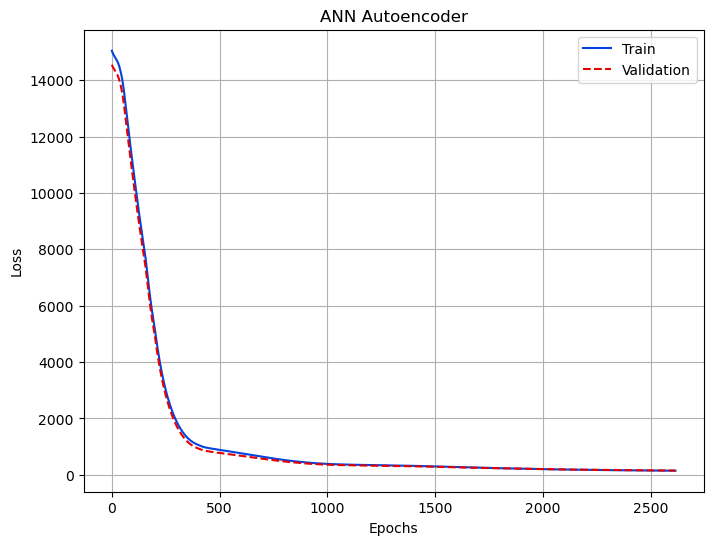

In [53]:
# Plot Train and Val loss
viz.plot_loss(history.history['loss'], history.history['val_loss'], title = 'ANN Autoencoder')

In [54]:
### Test the MAE and R^2 of the train, val and test datasets for the autoencoder
train_reconstructions = autoencoder.predict(train_data, BATCH_SIZE)
val_reconstructions   = autoencoder.predict(val_data, BATCH_SIZE)
test_reconstructions  = autoencoder.predict(test_data, BATCH_SIZE)

46/46 [==============================] - 0s 2ms/step


In [77]:
# Get the Mean RMSE values for each dataset
# Calculate the mean MAE and R^2 for each dataset
train_mae_list = []
train_r2_list  = []
train_rmse_list = []
for tri in range(train_data.shape[0]):
    train_mae = mean_absolute_error(train_data[tri], train_reconstructions[tri,:])
    train_r2  = r2_score(train_data[tri], train_reconstructions[tri,:])
    train_rmse = np.sqrt(mean_squared_error(train_data[tri], train_reconstructions[tri,:]))
    
    train_mae_list.append(train_mae)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    
test_mae_list  = []
test_r2_list   = []
test_rmse_list = []
for tei in range(test_data.shape[0]):
    test_mae = mean_absolute_error(test_data[tei], test_reconstructions[tei,:])
    test_r2  = r2_score(test_data[tei], test_reconstructions[tei,:])
    test_rmse = np.sqrt(mean_squared_error(test_data[tei], test_reconstructions[tei,:]))
    
    test_mae_list.append(test_mae)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)

val_mae_list   = []
val_r2_list    = []
val_rmse_list  = []
for vi in range(val_data.shape[0]):
    val_mae = mean_absolute_error(val_data[vi], val_reconstructions[vi,:])
    val_r2  = r2_score(val_data[vi], val_reconstructions[vi,:])
    val_rmse = np.sqrt(mean_squared_error(val_data[vi], val_reconstructions[vi,:]))
    
    val_mae_list.append(val_mae)
    val_r2_list.append(val_r2)
    val_rmse_list.append(val_rmse)

In [78]:
# Print the Mean MAE and R^2
print("Train MAE: ", np.mean(train_mae_list))
print("Val MAE: ", np.mean(val_mae_list))
print("Test MAE: ", np.mean(test_mae_list))
print("-"*40)
print("Train R-squared: ", np.mean(train_r2_list))
print("Val R-squared: ", np.mean(val_r2_list))
print("Test R-squared: ", np.mean(test_r2_list))
print("-"*40)
print("Train RMSE: ", np.mean(train_rmse_list))
print("Val RMSE: ", np.mean(val_rmse_list))
print("Test RMSE: ", np.mean(test_rmse_list))

Train MAE:  8.636938862341346
Val MAE:  7.272381015778092
Test MAE:  10.053667239649515
----------------------------------------
Train R-squared:  0.7573659667941902
Val R-squared:  0.8404690211538075
Test R-squared:  0.7682811280519878
----------------------------------------
Train RMSE:  10.81708376017344
Val RMSE:  9.14790057035622
Test RMSE:  12.083260025576013


In [79]:
### Plot the traces for Train, Test, Val ###
import matplotlib.pyplot as plt
import seaborn as sns

def legend_without_duplicate_labels(ax):
    '''https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib'''
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
def plot_traces(real_data, reconstructions, dataset='Train'):
    
    fig, ax = plt.subplots()

    pdx = np.random.choice(range(real_data.shape[0]), size = 1)

    ax.plot(real_data[pdx, :24].T, label = f'{dataset} True - Left', linestyle='-', color = 'xkcd:orange')
    ax.plot(real_data[pdx, 24:].T, label = f'{dataset} True - Right', linestyle='-', color = 'xkcd:red')

    ax.plot(reconstructions[pdx, :24].T, label = f'{dataset} Predictions - Left', linestyle='--', color = 'xkcd:blue')
    ax.plot(reconstructions[pdx, 24:].T, label = f'{dataset} Predictions - Right', linestyle='--', color = 'xkcd:black')
    
    ax.set_title(f'{dataset} Traces')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Glucose')
    
    legend_without_duplicate_labels(ax)
    return ax

<AxesSubplot:title={'center':'Val Traces'}, xlabel='Time Points', ylabel='Glucose'>

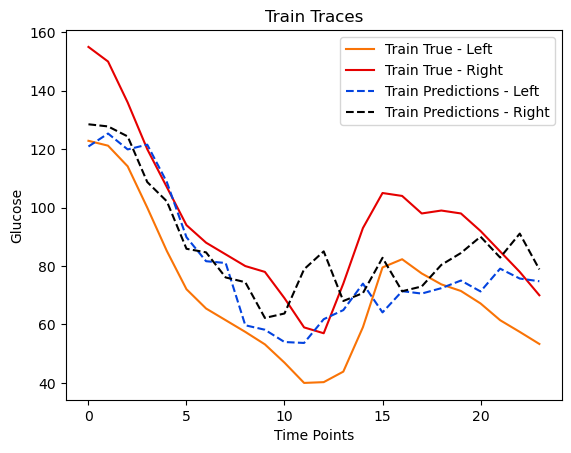

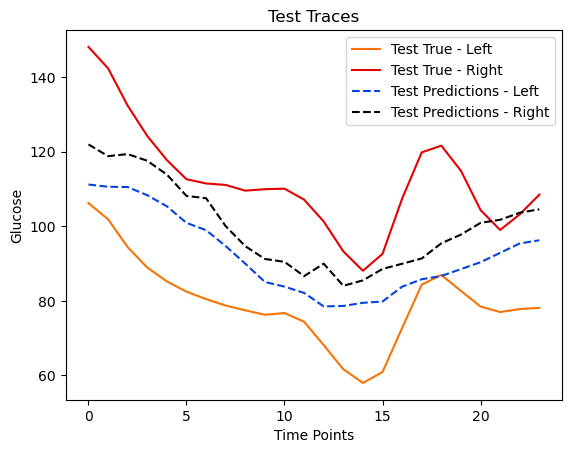

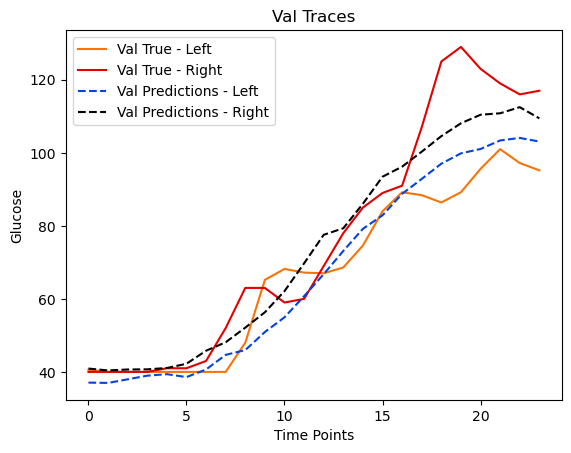

In [80]:
# Train #
plot_traces(train_data, train_reconstructions)

# Test #
plot_traces(test_data, test_reconstructions, 'Test')

# Validation #
plot_traces(val_data, val_reconstructions, 'Val')

## Try Classification via Thresholding

In [65]:
class ThresholdEstimator:

    def __init__(self) -> None:
        self.mu        = 0
        self.sigma     = 1
        self.threshold = None

    def fit(self, model, data, target):

        # Reconstruct the data
        reconstructions = model.predict(data)
        print("Reconstructions:")
        print(reconstructions[:5, :5])
        print("Data:")
        print(data[:5, :5])
        if len(data.shape) == 3:
            errors = tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data))
        else:
            errors = tf.keras.losses.mse(reconstructions, data)
        
        # Estimate the normal distribution of the errors
        self.mu    = np.mean(errors, axis = 0)
        self.sigma = np.cov(errors)

        #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
        likelihoods  = norm.pdf(errors, loc=self.mu, scale=self.sigma)
        print("Likelihoods:")
        print(likelihoods[:5])

        f_list = []
        
        #step_size = int((max(likelihoods) - min(likelihoods)) / 1000) # Too small for arange
        thresholds = np.linspace(min(likelihoods), max(likelihoods), 100)
        
        for t in thresholds:

            preds = (likelihoods<t).astype(int)
            f = fbeta_score(target, preds, beta=0.1)
            f_list.append(f)

        bidx = np.argmax(f_list)
        self.best_threshold = thresholds[bidx]
        #self.best_threshold = np.max(errors)
        #self.best_threshold = np.quantile(errors, 0.95) #thresholds[bidx]

        return self
    
    def _compress_array(self, array):
        compressed_array = [array[sample, array.shape[1]-1, :] for sample in range(array.shape[0])]
    
        return compressed_array
    
    def predict(self, model, data, target):
        
        reconstructions = model.predict(data)
        if len(data.shape) == 3:
            errors = np.array(tf.keras.losses.mse(self._compress_array(reconstructions), self._compress_array(data)))
        else:
            errors = np.array(tf.keras.losses.mse(reconstructions, data))
        print(errors[:5])
        #likelihoods = multivariate_normal.pdf(errors, mean=self.mu, cov=self.sigma)
        #likelihoods = norm.pdf(errors, loc=self.mu, scale=self.sigma)
        likelihoods = np.array(errors)
        print(likelihoods[:5])
        
        pred_labels = (likelihoods < self.best_threshold).astype(int)
        #likelihoods = errors
        #pred_labels = (errors > self.best_threshold).astype(int)
        return likelihoods, pred_labels

In [66]:
# Fit the threshold using the validation dataset.
ter = ThresholdEstimator()

ter.fit(autoencoder, val_data, y_val)

56/56 [==============================] - 0s 3ms/step
Reconstructions:
[[92.430565 93.27215  92.02773  91.17132  85.25645 ]
 [80.77592  80.49322  80.14764  78.42273  75.14772 ]
 [74.359    73.67816  73.63252  71.676605 69.18634 ]
 [71.43988  70.58418  70.452484 68.30539  65.680824]
 [67.74052  66.91112  66.58868  64.491905 61.714836]]
Data:
[[105.2  97.8  83.2  76.   74.2]
 [ 97.8  83.2  76.   74.2  68.4]
 [ 83.2  76.   74.2  68.4  62.2]
 [ 76.   74.2  68.4  62.2  58.6]
 [ 74.2  68.4  62.2  58.6  58. ]]
Likelihoods:
[5.85285985e-05 5.85272328e-05 5.85255245e-05 5.85250990e-05
 5.85250749e-05]


/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [67]:
test_preds, test_labels = ter.predict(autoencoder, test_data, y_test)

fpr_test, tpr_test, thresh_test = roc_curve(y_test, test_preds)
ppr_test, rec_test, pthresh_test = precision_recall_curve(y_test, test_preds)

print("Test AU-ROC: ", auc(fpr_test, tpr_test))
print("Test AU-PRC: ", auc(rec_test, ppr_test))
print("F-0.1 Score: ", fbeta_score(y_test, test_labels, beta=0.1))

183/183 [==============================] - 1s 3ms/step
[68.65852488 77.10350332 88.01731833 91.82335203 77.65324393]
[68.65852488 77.10350332 88.01731833 91.82335203 77.65324393]
Test AU-ROC:  0.38640396062271065
Test AU-PRC:  0.0015534564157980019
F-0.1 Score:  0.0


In [68]:
# Recombine full train and val data for testing
full_train_data, full_y_train = data[train_idx], target[train_idx]
full_val_data,   full_y_val   = data[val_idx], target[val_idx]

In [69]:
# Predict Train data
train_preds, train_labels = ter.predict(autoencoder, full_train_data, full_y_train)

fpr_train, tpr_train, thresh_train  = roc_curve(full_y_train, train_preds)
ppr_train, rec_train, pthresh_train = precision_recall_curve(full_y_train, train_preds)

print("Test AU-ROC: ", auc(fpr_train, tpr_train))
print("Test AU-PRC: ", auc(rec_train, ppr_train))
print("F-0.1 Score: ", fbeta_score(full_y_train, train_labels, beta=0.1))

75/75 [==============================] - 0s 3ms/step
[171.86039923 129.63831902 147.84939159 196.38190948 232.23465913]
[171.86039923 129.63831902 147.84939159 196.38190948 232.23465913]
Test AU-ROC:  0.4354310082241852
Test AU-PRC:  0.011921589607301195
F-0.1 Score:  0.0


In [70]:
# Predict Validation data
val_preds, val_labels = ter.predict(autoencoder, full_val_data, full_y_val)

fpr_val, tpr_val, thresh_val  = roc_curve(full_y_val, val_preds)
ppr_val, rec_val, pthresh_val = precision_recall_curve(full_y_val, val_preds)

print("Validation AU-ROC: ", auc(fpr_val, tpr_val))
print("Validation AU-PRC: ", auc(rec_val, ppr_val))
print("F-0.1 Score: ", fbeta_score(full_y_val, val_labels, beta=0.1))

57/57 [==============================] - 0s 2ms/step
[180.60361516  78.24247373  47.13382588  25.06046097  20.5411027 ]
[180.60361516  78.24247373  47.13382588  25.06046097  20.5411027 ]
Validation AU-ROC:  0.47719199850439337
Validation AU-PRC:  0.006224502936759781
F-0.1 Score:  0.0


In [71]:
anomalous_val

array([[101.8       , 103.6       , 106.4       , 112.6       ,
        117.2       , 119.6       , 120.        , 117.6       ,
        111.4       , 109.2       , 110.6       , 107.        ,
        105.2       ,  97.8       ,  83.2       ,  76.        ,
         74.2       ,  68.4       ,  62.2       ,  58.6       ,
         58.        ,  56.4       ,  49.6       ,  41.6       ,
        132.        , 134.        , 137.        , 142.        ,
        147.        , 154.        , 160.        , 157.        ,
        156.        , 161.        , 159.        , 147.        ,
        134.        , 112.        ,  88.        ,  74.        ,
         68.        ,  73.        ,  83.        ,  78.        ,
         75.        ,  73.        ,  63.        ,  57.        ],
       [250.        , 232.6       , 210.4       , 194.        ,
        176.6       , 157.        , 138.6       , 125.4       ,
        119.8       , 116.6       , 112.8       , 108.8       ,
        102.4       ,  93.        ,  87